## Time series model validation pipeline

#### Загрузим необходимые библиотеки для работы с данными

In [ ]:
!pip install sktime[all_extras] #запустить ячейку, потом перезапустить блокнот, и уже её не запускать

In [ ]:
!pip install tbats

In [ ]:
!pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import pandas as pd
import os

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
#from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

sns.set()
from IPython.lib.display import IFrame

#### Загрузим необходимые данные для анализа

In [103]:
train_sales = pd.read_excel("/data/train_sales_dist.xlsx",
                             parse_dates=True, index_col="Period")

## Разведочный анализ данных - факт продаж

Перед началом работы отсортируем имеющиеся данные по продажам по столбцу `Period`, чтобы было удобнее смотреть на табличные данные.

In [116]:
customer = 2
seasonal_period = 5
correct_data = False #для 2 и 29

In [117]:
train_sales = train_sales.sort_index()
data = train_sales[train_sales['Customer'] == customer][['BPV']]

if customer in [18,34]: #для СНГ предсказания по месяцам
  data = data.resample('MS').apply(sum)


if customer in [18,34]:
  window=12 #год для помесячных (18 и 34 клиенты)
  test_size = 9  #9 месяцев
if customer in [2,14,29]:
  window=26 #6 месяцев для понедельных (2,14,29 клиенты)
  test_size = round(52/12*9) #9 месяцев


if customer in [18,34]:
  freq = "M"
if customer in [2,14,29]:
  freq = "W"

In [ ]:
if correct_data:
  if customer == 2:
    data.loc[data.index<=pd.Timestamp("2020-02-24"),'BPV'] = data.loc[data.index<=pd.Timestamp("2020-02-24"),'BPV']/2
  elif customer == 29:
    data['BPV_gap'] = data['BPV'] 
    data.loc[data.index<pd.Timestamp("2020-01-01"),'BPV_gap'] = data['BPV'].shift(52)

    data = data[['BPV_gap']].rename({'BPV_gap':'BPV'}, axis=1)
    data = data.dropna()

### Аномалии

In [119]:
from outliers_detection import correct_outliers

In [121]:
data['corrected_BPV'] = correct_outliers(data['BPV'], window=6, scale=1.96, mode = 'next')
data['corrected_BPV_d'] = correct_outliers(data['BPV'], window=6, scale=1.96, mode = 'delete')

### Econometric

In [52]:
from plotting import tsplot

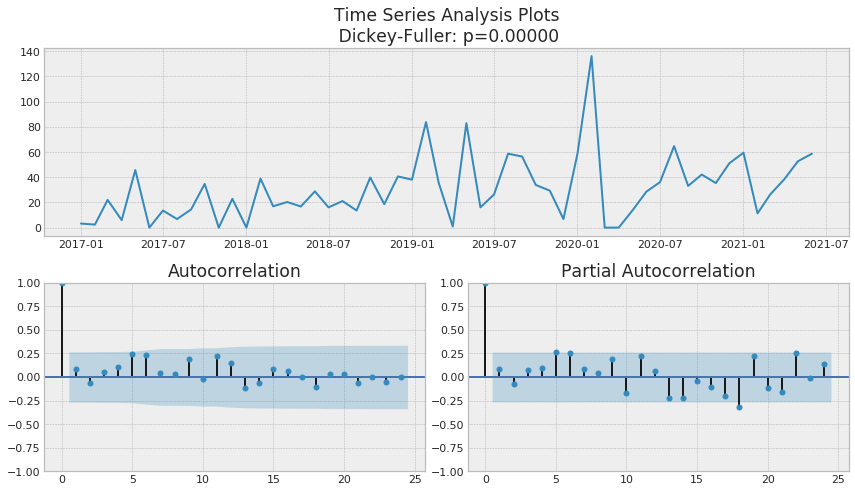

In [53]:
tsplot(data['BPV'], lags = 24)

### Code plots

In [54]:
from metrics import *
from plotting import *

In [ ]:
plotMovingAverage(data['BPV'], window, plot_intervals=True, scale=1.96, plot_anomalies=True)

# Модели

In [70]:
model_results = []

### Наивные

In [71]:
from models import train_test_split

In [72]:
def extending_window_cv_sktime(data, target_column, model, max_test_size: float):
  scores = []
  print(f"Максимальный размер тестовой выборки: {max_test_size} наблюдений")

  for n in range(max_test_size,0,-1):
    train, test = train_test_split(data[target_column], n)
    train.index = pd.PeriodIndex(train.index, freq=freq)
    test.index = pd.PeriodIndex(test.index, freq=freq)

    fh_test = ForecastingHorizon(test.index, is_relative=False)

    model.fit(train)
    preds = model.predict(fh_test)

    test.index = pd.to_datetime(test.index.strftime('%Y-%m-%d'))
    preds.index = pd.to_datetime(preds.index.strftime('%Y-%m-%d'))

    score =  wape(*resample_monthly(test, preds))
    scores.append(score)

  return np.array(scores).mean()

In [73]:
from sktime.forecasting.naive import NaiveForecaster

In [ ]:
for target_column in ['BPV', 'corrected_BPV', 'corrected_BPV_d']:
  model_results.append(["NaiveForecaster(strategy='last')",  target_column, extending_window_cv_sktime(data, target_column, NaiveForecaster(strategy='last'), max_test_size=test_size)])
  model_results.append([f"NaiveForecaster(sp={seasonal_period})",  target_column, extending_window_cv_sktime(data, target_column, NaiveForecaster(sp=seasonal_period), max_test_size=test_size)])

### ARIMA

In [76]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

In [77]:
forecaster_autoarima = AutoARIMA(start_p=1, d=None, start_q=0, 
                       max_p=3, max_d=3, max_q=3, 
                       start_P=1, D=1, start_Q=0, 
                       max_P=3, max_D=3, max_Q=3, 
                       sp=seasonal_period, suppress_warnings=True, stepwise=False, n_jobs=-1)

In [ ]:
# 42sec per iteration
for target_column in ['BPV', 'corrected_BPV', 'corrected_BPV_d']:
  model_results.append([f"AutoARIMA(sp={seasonal_period})", target_column, extending_window_cv_sktime(data, target_column, forecaster_autoarima, max_test_size=test_size)])

### ETS

In [80]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

es_forcaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=seasonal_period)

In [ ]:
for target_column in ['BPV', 'corrected_BPV', 'corrected_BPV_d']:
  model_results.append([f'ExponentialSmoothing(sp={seasonal_period})', target_column, extending_window_cv_sktime(data, target_column, es_forcaster, max_test_size=test_size)])
  model_results.append([f'AutoETS(sp={seasonal_period})', target_column, extending_window_cv_sktime(data, target_column, AutoETS(auto=True, sp=seasonal_period, n_jobs=-1), max_test_size=test_size)])

### TBATS

In [83]:
from tbats import TBATS

In [84]:
def extending_window_cv_tbats(data, target_column, model, max_test_size: float):
  scores = []
  print(f"Максимальный размер тестовой выборки: {max_test_size} наблюдений")

  for n in range(max_test_size,0,-1):###-7

    train, test = train_test_split(data[target_column], n)
    train.index = pd.PeriodIndex(train.index, freq=freq)
    test.index = pd.PeriodIndex(test.index, freq=freq)


    fitted_model = model.fit(train)
    preds = fitted_model.forecast(steps=n)

    test.index = pd.to_datetime(test.index.strftime('%Y-%m-%d'))


    preds = pd.Series(preds, index=test.index)
    preds = preds.resample('MS').apply(sum)
    test = test.resample('MS').apply(sum)
    score =  wape(test, preds)

    scores.append(score)

  return np.array(scores).mean()

In [85]:
for target_column in ['BPV', 'corrected_BPV', 'corrected_BPV_d']:
  model_results.append([f'TBATS(seasonal_periods=[4.35, 52.2]', target_column, extending_window_cv_tbats(data, target_column, TBATS(seasonal_periods=[4.35, 52.2]), max_test_size=test_size)])

Максимальный размер тестовой выборки: 9 наблюдений
Максимальный размер тестовой выборки: 9 наблюдений
Максимальный размер тестовой выборки: 9 наблюдений


### Prophet


In [ ]:
from fbprophet import Prophet

In [122]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.

       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
        historical.set_index("ds"))

In [123]:
def extending_window_cv_prophet(data, target_column, max_test_size: float, customer=customer, freq=freq):
  scores = []
  print(f"Максимальный размер тестовой выборки: {max_test_size} наблюдений")

  for n in range(max_test_size,0,-1):
    df = data[target_column].reset_index()
    df.columns = ["ds", "y"]

    train_df = df[:-n]
    m = Prophet()
    m.fit(train_df)

    future = m.make_future_dataframe(periods=n, freq = freq)

    if customer in [18,34]:
      future= future.set_index(['ds']).resample('MS').agg(sum)
      future= future.reset_index()
    
    forecast = m.predict(future)

    df = df.set_index("ds")
    df['pred'] = forecast["yhat"].values

    score = wape(*resample_monthly(df[-n:]['y'], df[-n:]['pred']))
    scores.append(score)

  return np.array(scores).mean()

In [ ]:
for target_column in ['BPV', 'corrected_BPV', 'corrected_BPV_d']:
  model_results.append(['Prophet', target_column, extending_window_cv_prophet(data, target_column, test_size, customer, freq)])

In [102]:
res_df = pd.DataFrame(model_results, columns=['model', 'target_column', 'score'])
res_df = res_df.pivot(index='model', columns='target_column', values = 'score')
res_df

target_column,BPV,corrected_BPV,corrected_BPV_d
model,,,
AutoARIMA(sp=5),0.251067,0.182454,0.245348
AutoETS(sp=5),0.307035,0.307007,0.310830
ExponentialSmoothing(sp=5),0.213873,0.191934,0.208766
NaiveForecaster(sp=5),0.170180,0.170180,0.170180
NaiveForecaster(strategy='last'),0.409086,0.409086,0.409086
Prophet,0.365563,0.388377,0.370002
"TBATS(seasonal_periods=[4.35, 52.2]",0.341483,0.338320,0.347248
